# Libraries

In [1]:
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset
from torch.optim import AdamW

from transformers.optimization import get_cosine_schedule_with_warmup
import torch_geometric as pyg
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        


In [3]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class TrainingConfig:
    # Training
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    lr_warmup_steps = 500

    device = "cuda"
    random_state = 42


config = TrainingConfig()
seed_everything(config.random_state)

# Data

In [4]:
df = pd.read_excel("data/19_35000.xlsx", index_col=0).reset_index(drop=True).dropna()
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [5]:
perc_99 = np.percentile(df["IC50"], 99)
df = df[df["IC50"] <= perc_99]

In [6]:
df.dtypes

Title      object
IC50      float64
SMILES     object
dtype: object

In [7]:
df["SMILES"] = df["SMILES"].apply(str)

/tmp/ipykernel_103546/3536902818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SMILES"] = df["SMILES"].apply(str)


In [14]:
unique_characters = set()

for el in tqdm(df["SMILES"].tolist()):
    unique_characters.update(set(el))

unique_characters = list(unique_characters)
unique_characters.insert(0, "<bos>")
unique_characters.insert(1, "<eos>")
unique_characters.insert(2, "<pad>")
unique_characters

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36013/36013 [00:00<00:00, 889551.89it/s]


['<bos>',
 '<eos>',
 '<pad>',
 '@',
 'a',
 '-',
 '2',
 'e',
 'Z',
 ']',
 'o',
 'P',
 '7',
 '+',
 'N',
 '8',
 '(',
 'n',
 'i',
 'H',
 'l',
 '9',
 'c',
 'F',
 'I',
 '[',
 'B',
 '1',
 '5',
 '#',
 'S',
 '6',
 's',
 '.',
 '3',
 'r',
 '4',
 '\\',
 ')',
 'C',
 '=',
 'O',
 '/']

In [15]:
vocab2id = dict()
id2vocab = dict()

for i in range(len(unique_characters)):
    vocab2id[unique_characters[i]] = i
    id2vocab[i] = unique_characters[i]

vocab2id, id2vocab

({'<bos>': 0,
  '<eos>': 1,
  '<pad>': 2,
  '@': 3,
  'a': 4,
  '-': 5,
  '2': 6,
  'e': 7,
  'Z': 8,
  ']': 9,
  'o': 10,
  'P': 11,
  '7': 12,
  '+': 13,
  'N': 14,
  '8': 15,
  '(': 16,
  'n': 17,
  'i': 18,
  'H': 19,
  'l': 20,
  '9': 21,
  'c': 22,
  'F': 23,
  'I': 24,
  '[': 25,
  'B': 26,
  '1': 27,
  '5': 28,
  '#': 29,
  'S': 30,
  '6': 31,
  's': 32,
  '.': 33,
  '3': 34,
  'r': 35,
  '4': 36,
  '\\': 37,
  ')': 38,
  'C': 39,
  '=': 40,
  'O': 41,
  '/': 42},
 {0: '<bos>',
  1: '<eos>',
  2: '<pad>',
  3: '@',
  4: 'a',
  5: '-',
  6: '2',
  7: 'e',
  8: 'Z',
  9: ']',
  10: 'o',
  11: 'P',
  12: '7',
  13: '+',
  14: 'N',
  15: '8',
  16: '(',
  17: 'n',
  18: 'i',
  19: 'H',
  20: 'l',
  21: '9',
  22: 'c',
  23: 'F',
  24: 'I',
  25: '[',
  26: 'B',
  27: '1',
  28: '5',
  29: '#',
  30: 'S',
  31: '6',
  32: 's',
  33: '.',
  34: '3',
  35: 'r',
  36: '4',
  37: '\\',
  38: ')',
  39: 'C',
  40: '=',
  41: 'O',
  42: '/'})

In [38]:
VOCAB_SIZE = len(vocab2id)
VOCAB_SIZE

43

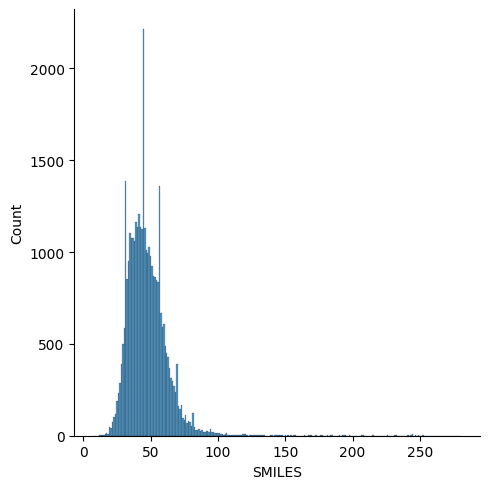

In [16]:
import seaborn as sns

lens = df["SMILES"].apply(len)

sns.displot(lens)

In [31]:
MAX_LEN = max(lens) + 2
MAX_LEN

283

## Clean

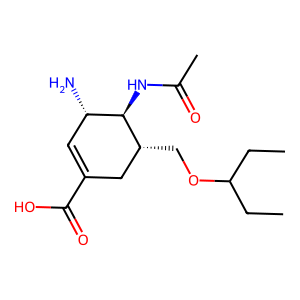

In [18]:
from rdkit import Chem
from rdkit.Chem import Draw

m = Chem.MolFromSmiles(df["SMILES"].tolist()[1])
img = Draw.MolToImage(m)
img

In [19]:
smiles = df["SMILES"].tolist()
target = df["IC50"].tolist()

In [32]:
def preprocess_smiles(word):
    chars = list(word)
    
    ids = [0] + [vocab2id[char] for char in chars] + [1]
    
    attn_mask = [0 for i in range(MAX_LEN - len(ids))] + [1 for i in range(len(ids))]
    pads = [2] * (MAX_LEN - len(ids))
    ids = pads + ids 

    return torch.LongTensor(ids).unsqueeze(0), torch.LongTensor(attn_mask).unsqueeze(0)
    

In [33]:
preprocess_smiles(smiles[0])

(tensor([[ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,
          25, 19

In [34]:
all_input_ids = []
all_attention_masks = []

for i in range(len(smiles)):
    input_ids, attn_mask = preprocess_smiles(smiles[0])
    all_input_ids.append(input_ids)
    all_attention_masks.append(attn_mask)

In [35]:
tensor_input_ids = torch.cat(all_input_ids, dim=0) 
tensor_attention_masks = torch.cat(all_attention_masks, dim=0) 

dataset = torch.utils.data.TensorDataset(tensor_input_ids, tensor_attention_masks, torch.tensor(target))

In [36]:
train_inds, test_inds = train_test_split(np.arange(df.shape[0]))
train_inds

array([ 7966, 34158, 35159, ..., 34202, 10226, 25150])

In [37]:
train_loader = DataLoader(
    Subset(dataset, train_inds),
    shuffle=True,
    batch_size=config.batch_size
)

eval_loader = DataLoader(
    Subset(dataset, test_inds),
    shuffle=True,
    batch_size=config.batch_size
)

In [58]:
from torch import nn

class SMILESLSTM(nn.Module):
    def __init__(self, embedding_dim, num_layers, bidirectional = True):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=embedding_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.out = nn.Linear(embedding_dim * (1 + bidirectional), 1)
        self.gelu = nn.GELU()
        
    def forward(self, input_ids, attention_masks):
        x = self.embedding(input_ids) # cfm multiply by attn mask??))?)??)?
        B, T, E = x.shape

        x = x * attention_masks.unsqueeze(dim=-1)
        x, (h, c) = self.lstm(x)
        
        x = self.out(x[:, T - 1])
        
        return x


model = SMILESLSTM(embedding_dim=128, num_layers=3, bidirectional=False)
model

SMILESLSTM(
  (embedding): Embedding(43, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (gelu): GELU(approximate='none')
)

In [59]:
optimizer = AdamW(model.parameters(), lr=config.learning_rate)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.epochs),
)

loss_function = torch.nn.L1Loss()

# Let's Train

In [60]:
def train_epoch(model, loader, loss_function, optimizer, scheduler, device):
    model.train()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        input_ids, attention_masks, y = batch
        input_ids, attention_masks, y = input_ids.to(device), attention_masks.to(device), y.to(device)
        output = model(input_ids, attention_masks)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"TRAIN Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}
        
        
def eval_epoch(model, loader, loss_function, device):
    model.eval()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        input_ids, attention_masks, y = batch
        input_ids, attention_masks, y = input_ids.to(device), attention_masks.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(input_ids, attention_masks)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"EVAL Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}

In [61]:
train_logs, eval_logs = [], []

for i in range(config.epochs):
    train_log = train_epoch(
        model=model, 
        loader=train_loader, 
        loss_function=loss_function, 
        optimizer=optimizer,
        scheduler=scheduler,
        device=config.device
    )
    
    eval_log = eval_epoch(
        model=model, 
        loader=eval_loader, 
        loss_function=loss_function, 
        device=config.device
    )

    print(train_log, eval_log)
    
    train_logs.append(train_log)
    eval_logs.append(eval_log)

  0%|                                                                                                                                      | 0/14 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.54 GiB. GPU 